In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import joblib

In [4]:
from skimage.feature import local_binary_pattern
def lbp_histogram(image, radius, bins):
    # compute the LBP histogram of the image
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp, bins= bins, density=True)
    return np.ravel(hist)

def lbp_histogram_transfrom(npdata):
    number_image = 100
    radius = 8
    bins = 32
    img=np.zeros(shape=(number_image, bins)) 
    for i in range(0,number_image):
         img[i] = lbp_histogram(npdata['data'][i], radius, bins)
    print(img.shape)
    
    # make dataset in Bunch format 
    return img

c:\Python310\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(1265, 9)
(1265,)
[64, 121, 264, 321]
[104, 121, 304, 321]
[144, 121, 344, 321]
[184, 121, 384, 321]
[224, 121, 424, 321]
[264, 121, 464, 321]
[304, 121, 504, 321]
[344, 121, 544, 321]
[384, 121, 584, 321]
[424, 121, 624, 321]
[464, 121, 664, 321]
[504, 121, 704, 321]
[544, 121, 744, 321]
[584, 121, 784, 321]
[624, 121, 824, 321]
[664, 121, 864, 321]
[704, 121, 904, 321]
[744, 121, 944, 321]
[784, 121, 984, 321]
[824, 121, 1024, 321]
[864, 121, 1064, 321]
[904, 121, 1104, 321]
[944, 121, 1144, 321]
[984, 121, 1184, 321]
[1024, 121, 1224, 321]
[1064, 121, 1264, 321]
[1104, 121, 1304, 321]
[1144, 121, 1344, 321]
[1184, 121, 1384, 321]
[1224, 121, 1424, 321]
[1264, 121, 1464, 321]
[1304, 121, 1504, 321]
[1344, 121, 1544, 321]
[1384, 121, 1584, 321]
[1424, 121, 1624, 321]
[1464, 121, 1664, 321]
[1504, 121, 1704, 321]
[1544, 121, 1744, 321]
[1584, 121, 1784, 321]
[1624, 121, 1824, 321]
[1664, 121, 1864, 321]
[1704, 121, 1904, 321]
[1744, 121, 1944, 321]
[1784, 121, 1984, 321]
[1824, 121, 20

True

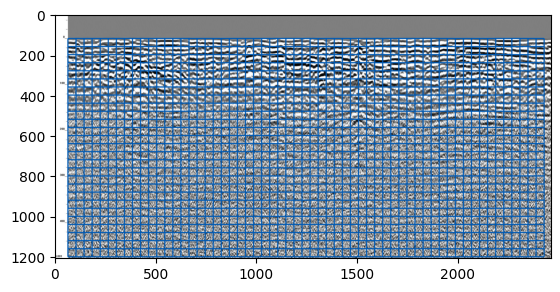

In [63]:
IMAGE_START = 64
AXIS_ZERO = 121

model_name = "svm_model.joblib"
model = joblib.load(model_name)
image_path = "../data_preprocessing/processed/WLT_350_210926 P_2111131 WLT_350_210926__008 P_2111131_processed.JPG"

sliding_window_size = 200
step = 40
img = cv2.imread(image_path)

radius = 1
bins = 8

labeled = []
number_image = 0
for j in range(AXIS_ZERO, img.shape[0] - sliding_window_size, step):
    for i in range(IMAGE_START, img.shape[1]- sliding_window_size, step):
        number_image += 1
features=np.zeros(shape=(number_image, bins + 1))

count = 0
for j in range(AXIS_ZERO, img.shape[0] - sliding_window_size, step):
    for i in range(IMAGE_START, img.shape[1]- sliding_window_size, step):
        sliding_window = [i, j, i + sliding_window_size, j + sliding_window_size]
        if i + sliding_window_size > img.shape[1] - 1:
            sliding_window[0] = img.shape[1] - 1 - sliding_window_size
            sliding_window[2] = img.shape[1] - 1
        if j + sliding_window_size > img.shape[0] - 1:
            sliding_window[1] = img.shape[0] - 1 - sliding_window_size
            sliding_window[3] = img.shape[0] - 1

        cropped = img[sliding_window[1]:sliding_window[3], sliding_window[0]:sliding_window[2]]
        rgb_weights = [0.2989, 0.5870, 0.1140]
        cropped = np.dot(cropped[...,:3], rgb_weights)
        cropped = np.array(cropped).astype(np.uint8)
        features[count, :bins] = lbp_histogram(cropped, radius, bins)
        features[count, bins] = j
        count += 1

# normalize lbp
for i in range(number_image):
    norm = np.linalg.norm(features[i, :])
    for j in range(bins):
        features[i, j] = features[i, j] / norm
        
norm = np.linalg.norm(features[:, bins])
for i in range(number_image):
    features[i, bins] = features[i, bins] / norm

validate_result = model.predict(features)

print(features.shape)
print(validate_result.shape)

count = 0
for j in range(AXIS_ZERO, img.shape[0] - sliding_window_size, step):
    for i in range(IMAGE_START, img.shape[1]- sliding_window_size, step):
        sliding_window = [i, j, i + sliding_window_size, j + sliding_window_size]
        if i + sliding_window_size > img.shape[1] - 1:
            sliding_window[0] = img.shape[1] - 1 - sliding_window_size
            sliding_window[2] = img.shape[1] - 1
        if j + sliding_window_size > img.shape[0] - 1:
            sliding_window[1] = img.shape[0] - 1 - sliding_window_size
            sliding_window[3] = img.shape[0] - 1
        if validate_result[count] == 1:
            # is_merged = False
            # for box in labeled:
            #     if not ((sliding_window[1] > box[3] or sliding_window[3] < box[1]) and (sliding_window[0] > box[2] or sliding_window[2] < box[0])):
            #         print(sliding_window)
            #         print(box)
            #         box[0] = min(sliding_window[0], box[0])
            #         box[1] = min(sliding_window[1], box[1])
            #         box[2] = max(sliding_window[2], box[2])
            #         box[3] = max(sliding_window[3], box[3])
            #         is_merged = True
            #         print("merged: ", box)
            #         break
            # if not is_merged:
            #     labeled.append(sliding_window)
            labeled.append(sliding_window)
            print(sliding_window)
        count+=1

box_width = 3
for box in labeled:
    for i in range(3):
        img[box[1] - box_width:box[1] + box_width, box[0]:box[2], i] = 90 * i * np.ones_like(img[box[1] - box_width:box[1] + box_width, box[0]:box[2], i])
        img[box[3] - box_width:box[3] + box_width, box[0]:box[2], i] = 90 * i * np.ones_like(img[box[3] - box_width:box[3] + box_width, box[0]:box[2], i])
        img[box[1]:box[3], box[0] - box_width:box[0] + box_width, i] = 90 * i * np.ones_like(img[box[1]:box[3], box[0] - box_width:box[0] + box_width, i])
        img[box[1]:box[3], box[2] - box_width:box[2] + box_width, i] = 90 * i * np.ones_like(img[box[1]:box[3], box[2] - box_width:box[2] + box_width, i])
plt.imshow(img)
cv2.imwrite('outut.jpg', img)